In [262]:
from PythonCode.architecture import Architecture
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import colorsys
from matplotlib.colors import Normalize

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Running Experiments

In [2]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

def load_mnist_data(subset_size=None):
    # 1) Download MNIST via openml
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist['data'].astype(np.float32) / 255.0        # [70000, 784] in [0,1]
    y = mnist['target'].astype(np.int64)               # integer labels 0–9

    # 2) Split into 60 k train / 10 k test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        train_size=5000,
        test_size=1000,
        random_state=42,
        stratify=y
    )

    # 3) One-hot encode labels for MSELoss compatibility
    num_classes = 10
    y_train_oh = np.eye(num_classes, dtype=np.float32)[y_train]  # [60000,10]
    y_test_oh  = np.eye(num_classes, dtype=np.float32)[y_test]   # [10000,10]

    return X_train, y_train_oh, X_test, y_test_oh

x_train, y_train, x_test, y_test = load_mnist_data()
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test : {x_test.shape},  y_test : {y_test.shape}")

x_train: (5000, 784), y_train: (5000, 10)
x_test : (1000, 784),  y_test : (1000, 10)


In [8]:
depths = [1,2,3,4,5,6,7,8,9,10]
num_guesses = 25
arch_data2 = []

for depth in depths:
    
    print(f"Training a {depth}-layer MLP on MNIST")
    arch = Architecture(depth)
    
    arch_datum = arch.run_experiment(num_guesses,
                                     x_train, y_train, 
                                     x_test, y_test)
    
    arch_data2.append(arch_datum)

Training a 1-layer MLP on MNIST
Training a 2-layer MLP on MNIST
Training a 3-layer MLP on MNIST
Training a 4-layer MLP on MNIST
Training a 5-layer MLP on MNIST
Training a 6-layer MLP on MNIST
Training a 7-layer MLP on MNIST
Training a 8-layer MLP on MNIST
Training a 9-layer MLP on MNIST
Training a 10-layer MLP on MNIST


### Data Analysis

arch_data.shape ≈ (10 depths) × (25 guesses) × (4 result fields)

[i,j] = (depth, random start)

arch_data[i,j] contains 4 elements:
- parameter vector
- losses list
- hessian eigenvalues
- validation error

In [329]:
# torch.save(arch_data2, "trial2.pt")
arch_data = torch.load("trial2.pt")

In [ ]:
depths = [1,2,3,4,5,6,7,8,9,10]
num_guesses = 25

# ─── Containers ───────────────────────────────────────────────────────────────
all_params = []   # will hold (num_guesses × num_params) arrays
all_final  = []   # will hold (num_guesses,) arrays of final loss
all_eigs   = []   # will hold (num_guesses × num_params) arrays
all_val    = []   # will hold (num_guesses,) arrays of validation errors

# ─── Build the arrays ─────────────────────────────────────────────────────────
for depth_idx, runs in enumerate(arch_data):
    # runs is a list of length num_guesses
    # each run = [ params_tensor, losses_list, eigs_tensor, val_error_float ]

    # 1) Stack the optimal parameter vectors into a 2D array
    params_arr = np.stack([ run[0].numpy() for run in runs ], axis=0)
    all_params.append(params_arr)

    # 2) Extract the final (optimal) training loss from each run
    final_losses = np.array([ run[1][-1] for run in runs ])
    all_final.append(final_losses)

    # 3) Stack the Hessian eigenvalue vectors
    eigs_arr = np.array([ run[2] for run in runs ])
    all_eigs.append(eigs_arr)

    # 4) Collect the validation‐loss scalars
    val_losses = np.array([ run[3] for run in runs ])
    all_val.append(val_losses)

# e.g. check shapes for the first depth:
k = 0
print(f"Depth = {depths[k]}")
print(" params shape:", all_params[k].shape)
print(" final loss shape:", all_final[k].shape)
print(" eigs shape:", all_eigs[k].shape)
print(" val loss shape:", all_val[k].shape)

Depth = 1
 params shape: (25, 38170)
 final loss shape: (25,)
 eigs shape: (25,)
 val loss shape: (25,)


In [331]:
## Create a numpy array of 10, 2, 25 (depth, curvature or loss, num_guesses)
loss_curvature = np.zeros((len(depths), 2, num_guesses))

# Populate
for depth in depths:
    for i in range(num_guesses):
        loss_curvature[depth-1, 0, i] = all_final[depth-1][i]
        loss_curvature[depth-1, 1, i] = all_eigs[depth-1][i]

Initial loss: 5.616205537026714
Final loss: 4.737383191870055
Percentage improvement: 15.647973340055454
Estimated lambda_G: 0.41540024828226857


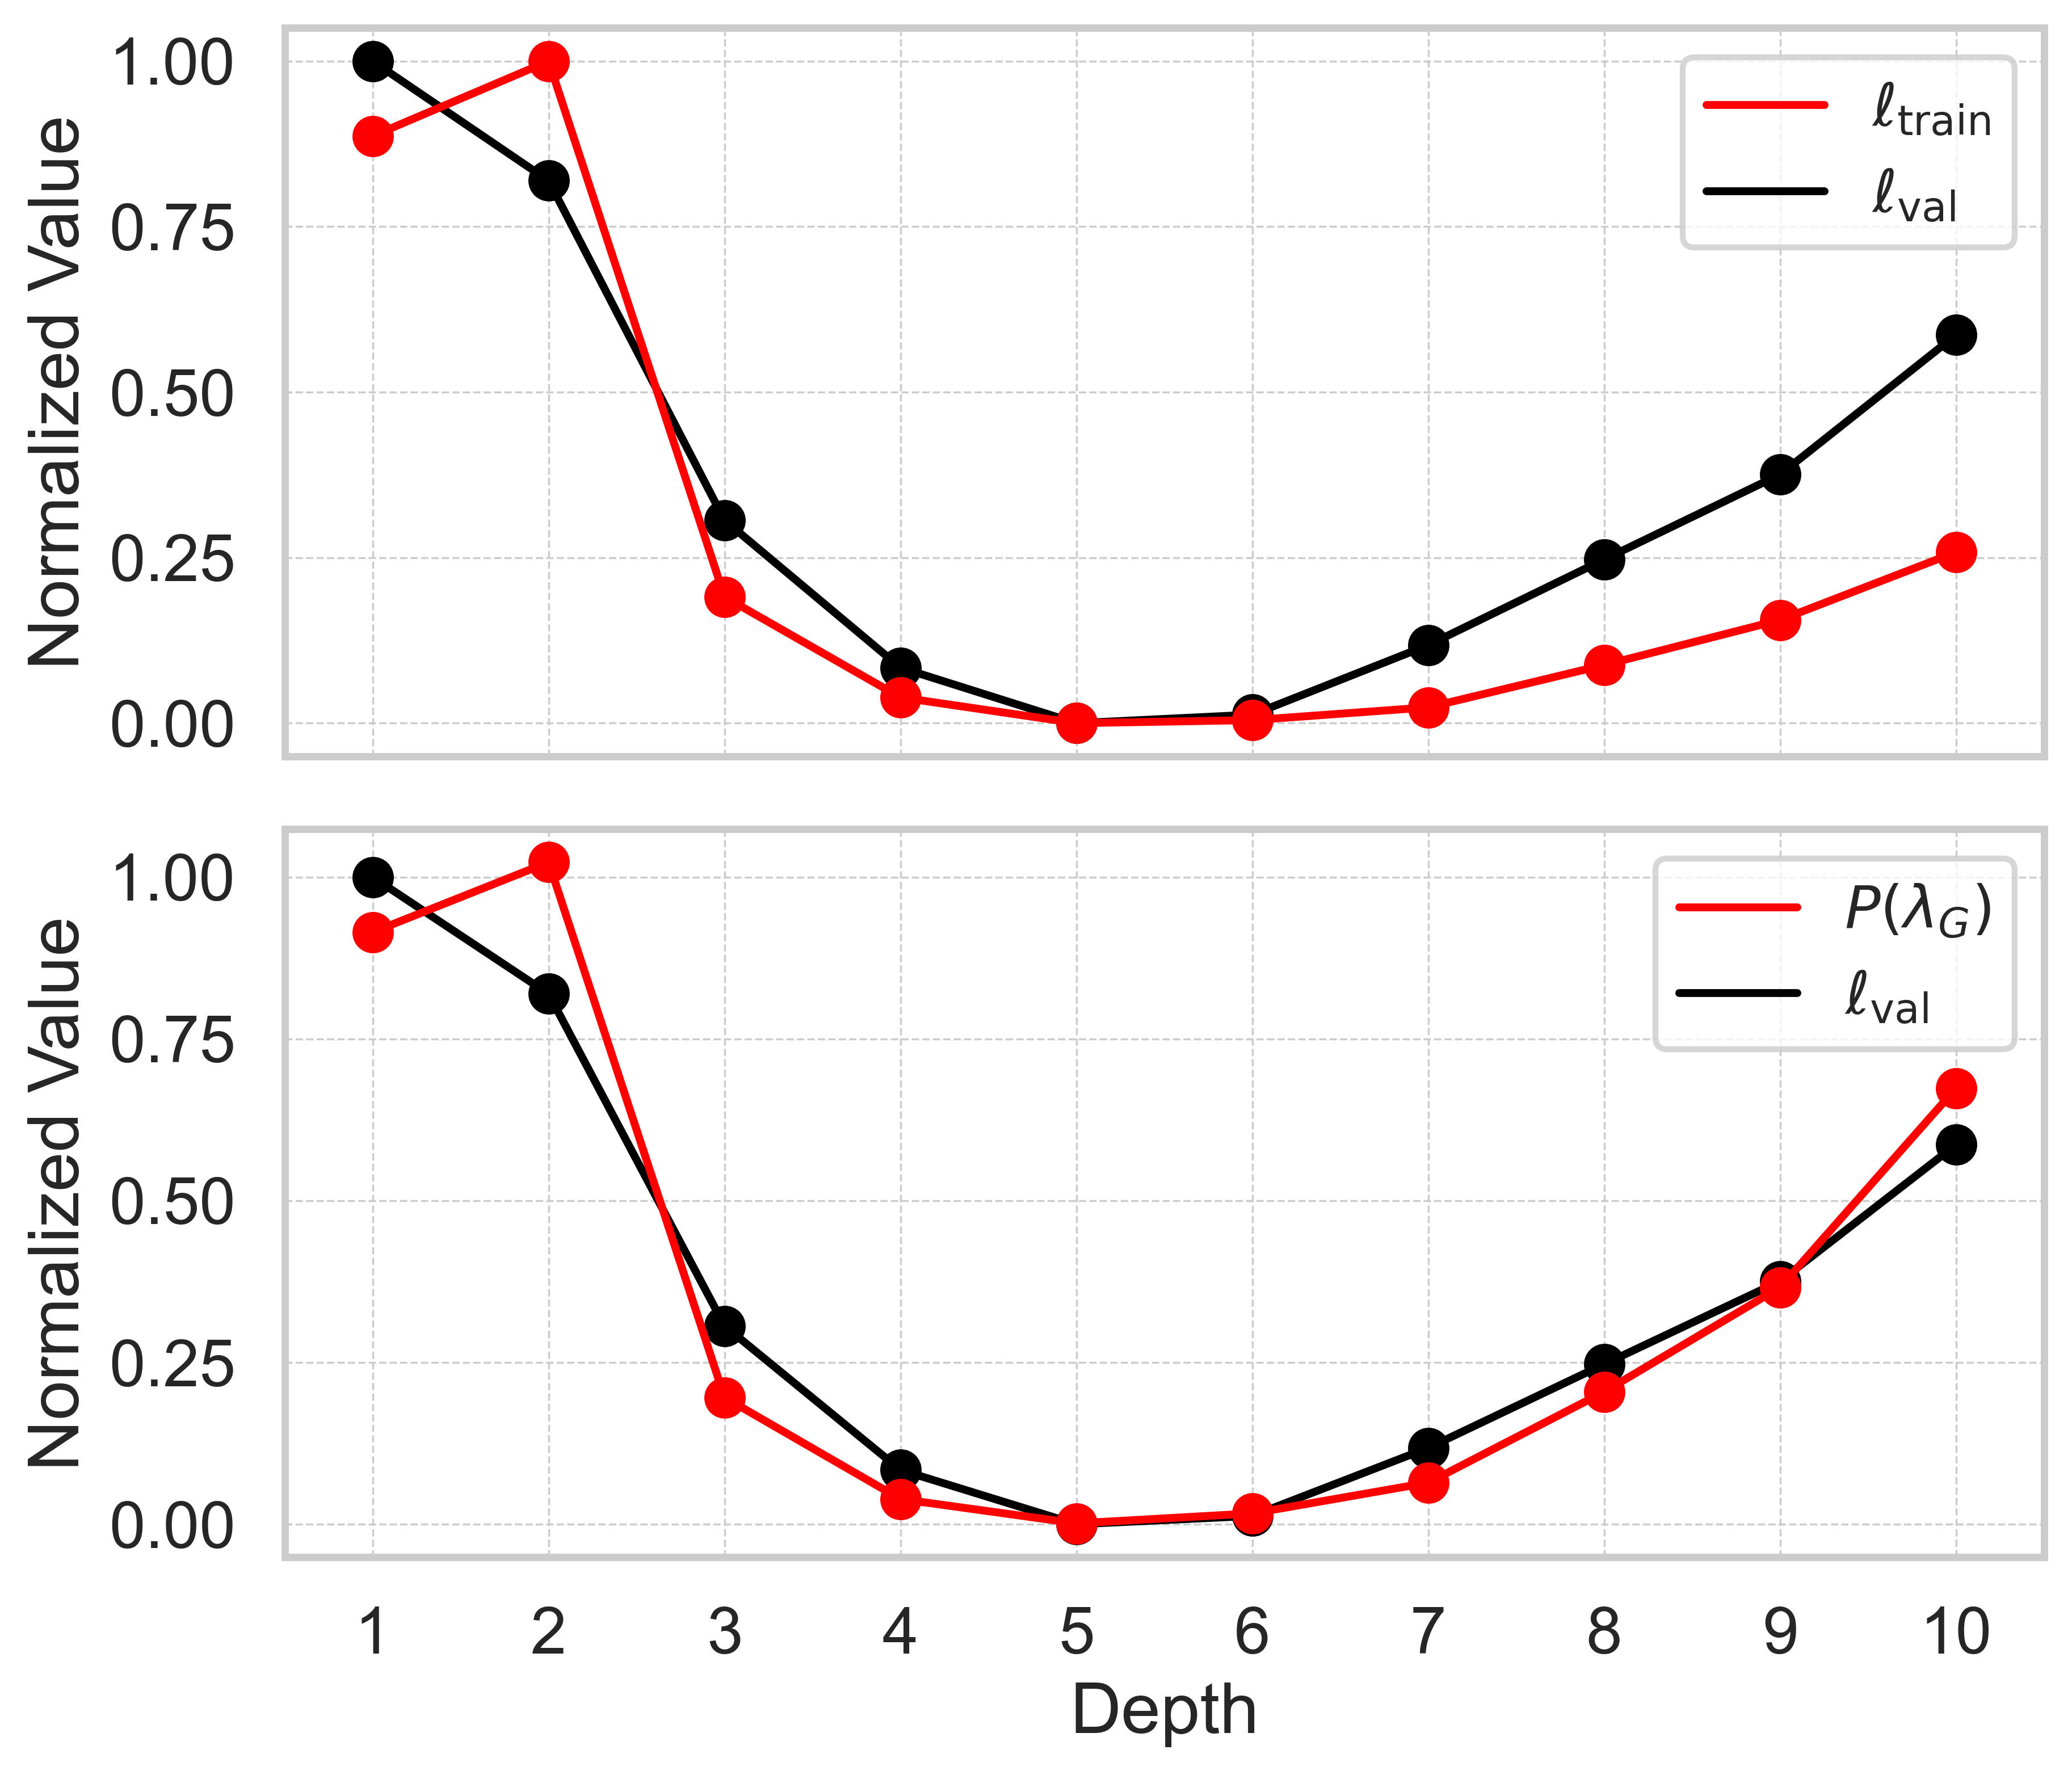

In [650]:
import numpy as np
import matplotlib.pyplot as plt

def minimax2(x):
    x_min = np.min(np.mean(x, axis=1))
    x_max = np.max(np.mean(x, axis=1))
    return (x - x_min) / (x_max - x_min)

# Unpack into (D, R) arrays
losses = loss_curvature[:, 0, :]       # shape (D, R)
curvatures = loss_curvature[:, 1, :]   # shape (D, R)
val_losses = np.array(all_val)         # shape (D, R)

# Normalize using min max
losses_n = minimax2(losses)
curvatures_n = minimax2(curvatures)
val_losses_n = minimax2(val_losses)

from scipy.optimize import minimize_scalar
def estimate_lambda_G(losses_n, curvatures_n, val_losses_n):
    # Objective function to minimize
    def objective(lambda_G):
        proxy = losses_n + lambda_G * curvatures_n

        # USE MSE as the loss
        #loss = np.sum((proxy - val_losses_n) ** 2) / len(val_losses_n)

        # Use MAE instead
        loss = np.sum(np.abs(proxy - val_losses_n)) / len(val_losses_n)

        return loss
    
    print('Initial loss:', objective(0))

    # Use a scalar minimization method
    result = minimize_scalar(objective, bounds=(0, 1), method='bounded')

    print('Final loss:', result.fun)
    print('Percentage improvement:', (objective(0) - result.fun) / objective(0) * 100)

    return result.x

# Estimate lambda_G using the objective function
lambda_G = estimate_lambda_G(losses_n, curvatures_n, val_losses_n)

#percentage improvement
print(f"Estimated lambda_G: {lambda_G}")

# Calculate the proxy
proxy = losses_n + lambda_G * curvatures_n

# Calculate means and standard deviations
loss_n = np.mean(losses_n, axis=1)
curv_n = np.mean(curvatures_n, axis=1)
val_n = np.mean(val_losses_n, axis=1)
proxy_n = np.mean(proxy, axis=1)
proxy_err = np.std(proxy, axis=1)
loss_err = np.std(losses_n, axis=1)
curv_err = np.std(curvatures_n, axis=1)
val_err = np.std(val_losses_n, axis=1)

# 1) Set up figure and subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), dpi=500)
fig.subplots_adjust(hspace=0.1)
sns.set_context("talk", font_scale=1)

# Shared x‐ticks
depths_arr = np.array(depths)
for ax in (ax1, ax2):
    ax.set_xticks(depths_arr)
    ax.set_xlim(depths_arr.min() - 0.5, depths_arr.max() + 0.5)

# ----- Top panel: Training + Validation Loss -----
ax1.plot(depths_arr, loss_n,  color='red', label=r'$\ell_{\rm train}$', lw=2, zorder = 2)
ax1.scatter(depths_arr, loss_n, color='red',zorder = 2)
# ax1.fill_between(depths_arr, loss_n - loss_err, loss_n + loss_err,
#                  color='blue', alpha=0.1, zorder = 2)

ax1.plot(depths_arr, val_n,   color='black', label=r'$\ell_{\rm val}$', lw=2, zorder = 1)
ax1.scatter(depths_arr, val_n, color='black', zorder = 1)
# ax1.fill_between(depths_arr, val_n - val_err, val_n + val_err,
#                  color='black', alpha=0.1, zorder = 1)

ax1.set_ylabel('Normalized Value')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend(loc='upper right', fontsize='small')
ax1.set_xticklabels([])   # hide x‐labels on top panel

# ----- Bottom panel: Proxy P(λ_G) vs Depth -----
ax2.plot(depths_arr, proxy_n, color='red',   label=r'$P(\lambda_G)$', lw=2, zorder = 2)
ax2.scatter(depths_arr, proxy_n, color='red', zorder = 2)
# ax2.fill_between(depths_arr, proxy_n - proxy_err, proxy_n + proxy_err,
#                  color='green', alpha=0.1, zorder = 2)

ax2.plot(depths_arr, val_n,  color='black', label=r'$\ell_{\rm val}$', lw=2, zorder = 1)
ax2.scatter(depths_arr, val_n, color='black', zorder = 1)
# ax2.fill_between(depths_arr, val_n - val_err, val_n + val_err,
#                  color='black', alpha=0.1, zorder = 1)

ax2.set_xlabel('Depth')
ax2.set_ylabel('Normalized Value')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper right', fontsize='small')

plt.show()

In [332]:
def compute_pareto_fronts(data):

    D, _, R = data.shape
    list_of_fronts = []
    
    for d in range(D):
        # shape (R, 2): each row is (loss, curvature)
        pts = data[d].T.copy()
        
        # assume all points are Pareto‐optimal until proven otherwise
        is_pareto = np.ones(R, dtype=bool)
        
        # for each point i, check if any other point j dominates it
        for i in range(R):
            for j in range(R):
                if i == j:
                    continue
                # j dominates i if:
                #  loss_j <= loss_i AND curv_j <= curv_i
                #  AND at least one is strict
                if (pts[j, 0] <= pts[i, 0] and
                    pts[j, 1] <= pts[i, 1] and
                    (pts[j, 0] < pts[i, 0] or pts[j, 1] < pts[i, 1])):
                    is_pareto[i] = False
                    break
        
        # collect the non‐dominated points
        pareto_pts = pts[is_pareto]
        
        # sort by curvature (column 1) for monotonic plotting
        sort_idx = np.argsort(pareto_pts[:, 1])
        pareto_pts_sorted = pareto_pts[sort_idx]
        
        list_of_fronts.append(pareto_pts_sorted)
    
    return list_of_fronts

# Compute the Pareto fronts
pareto_fronts = compute_pareto_fronts(loss_curvature)

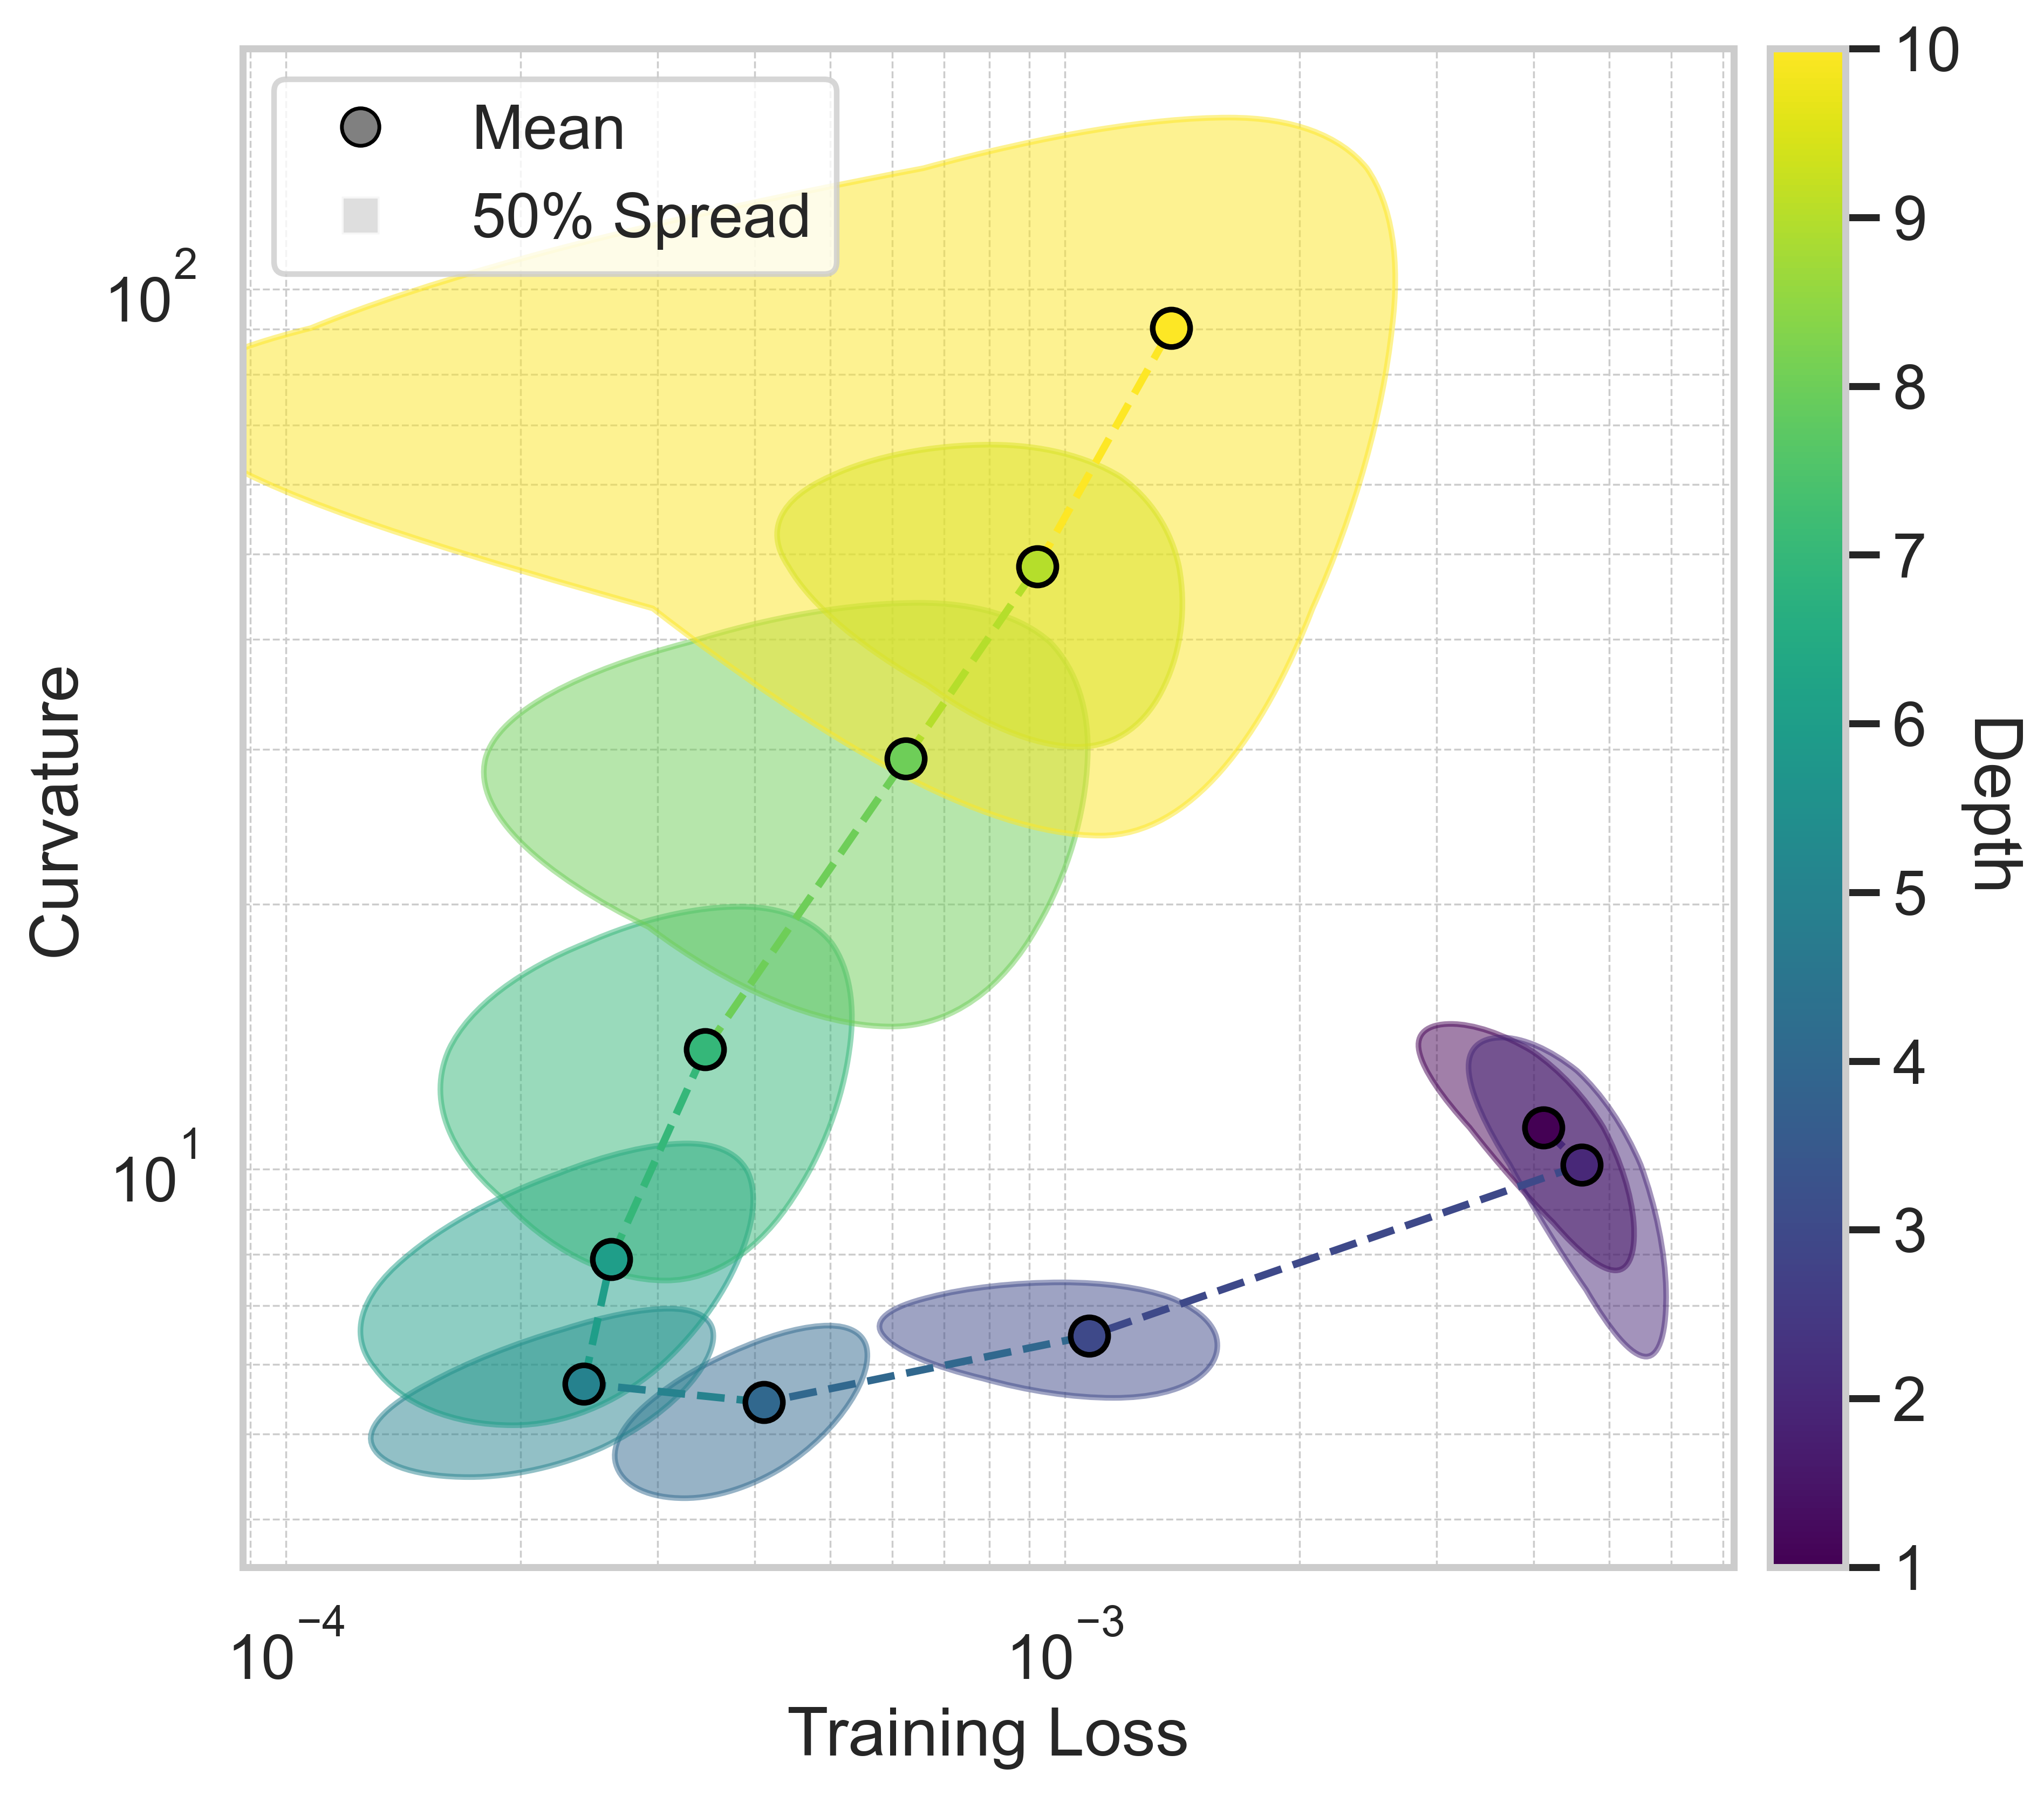

In [576]:
# 1) Set up figure and main Axes
fig, ax = plt.subplots(figsize=(8, 7), dpi=500)
sns.set_context("talk", font_scale=1)

# 2) Create a Normalize instance and colormap for depth
depths_arr = np.array(depths)
norm = Normalize(vmin=depths_arr.min(), vmax=depths_arr.max())
cmap = plt.cm.viridis

# # 3) Plot each front, colored by its depth
# for d, front in zip(depths_arr, pareto_fronts):
#     color = cmap(norm(d))
#     ax.scatter(front[:, 0], front[:, 1],
#                color=color, marker='o', s=50)
#     # Plot the Pareto front line with dashes
#     ax.plot(front[:, 0], front[:, 1], color=color, lw=2, linestyle='--')

mean_points = []

for i, sets in enumerate(loss_curvature):
    color = cmap(norm(depths_arr[i]))

    loss_vals, curv_vals = loss_curvature[i]  # each is shape (25,)
    mean_loss = np.mean(loss_vals)
    mean_curv = np.mean(curv_vals)

    mean_points.append((mean_loss, mean_curv))

    # Plot the mean point outline in black
    ax.scatter(mean_loss, mean_curv,
               color=color, marker='o', s=100, edgecolor = 'black', zorder = 3)
    
    # Add the ellipses for the confidence regions
    # 1) Compute the covariance matrix
    cov = np.cov(loss_vals, curv_vals)
    # 2) Compute the eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eig(cov)
    # 3) Compute the angle of rotation
    angle = np.arctan2(eigvecs[1, 0], eigvecs[0, 0])
    # 4) Compute the width and height of the ellipse
    width = 2 * np.sqrt(eigvals[0])
    height = 2 * np.sqrt(eigvals[1])
    # 5) Create the ellipse

    ellipse = plt.matplotlib.patches.Ellipse(
        xy=(mean_loss, mean_curv),
        width=width, height=height,
        angle=np.degrees(angle),
        color=color, alpha=0.5, zorder = 1
    )
    ax.add_patch(ellipse)

# Draw dashed connectors
for i in range(1, len(mean_points)):
    color = cmap(norm(depths_arr[i]))
    x0, y0 = mean_points[i-1]
    x1, y1 = mean_points[i]
    ax.plot(
        [x0, x1], [y0, y1],
        linestyle='--',
        color=color,
        linewidth=2,
        zorder=2
    )

# 4) Formatting
ax.set_xlabel('Training Loss')
ax.set_ylabel("Curvature")
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_title("Loss and Curvature at Optimal Parameters")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# 5) Add a depth colorbar, tied to this Axes
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # needed for the colorbar
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label("Depth", rotation=270, labelpad=15)
cbar.set_ticks(depths_arr)

# Add a legend with 2 elements [50% spread, Mean]
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Mean',
               markerfacecolor='gray', markersize=10, markeredgecolor= 'black', zorder=2),
    plt.Line2D([0], [0], marker='s', color='w', label='50% Spread',
               markerfacecolor='lightgray', markersize=10, alpha=0.75, zorder=1)
]
ax.legend(handles=legend_elements, loc='upper left')

plt.tight_layout()
plt.show()

In [334]:
import numpy as np

def normalize_loss_curvature(data):
    """
    data: np.ndarray, shape (D,2,R)
      data[d,0,:] = loss array at depth d
      data[d,1,:] = curvature array at depth d
    Returns a new array of the same shape with each axis min–max normalized globally.
    """
    # global min/max per objective
    min_loss, max_loss = data[:,0,:].min(), data[:,0,:].max()
    min_curv, max_curv = data[:,1,:].min(), data[:,1,:].max()
    
    norm = np.empty_like(data)
    norm[:,0,:] = (data[:,0,:] - min_loss) / (max_loss - min_loss)
    norm[:,1,:] = (data[:,1,:] - min_curv) / (max_curv - min_curv)
    return norm

def compute_pareto_fronts(data):
    """
    data: np.ndarray, shape (D,2,R)
    returns: list of length D of arrays (P_d,2) sorted by increasing curvature
    """
    D, _, R = data.shape
    fronts = []
    for d in range(D):
        pts = data[d].T  # shape (R,2): (loss, curv)
        is_pareto = np.ones(R, bool)
        for i in range(R):
            # if any other point j strictly dominates i, knock it out
            if any(
                (pts[j,0] <= pts[i,0] and pts[j,1] <= pts[i,1]) and
                (pts[j,0] < pts[i,0] or pts[j,1] < pts[i,1])
                for j in range(R) if j!=i
            ):
                is_pareto[i] = False
        pf = pts[is_pareto]
        # sort by curvature (col 1)
        idx = np.argsort(pf[:,1])
        fronts.append(pf[idx])
    return fronts

from scipy.spatial import ConvexHull

def compute_hull_fronts(data):
    fronts = []
    for d in range(data.shape[0]):
        pts = data[d].T  # (R,2)
        hull = ConvexHull(pts)
        # pick hull vertices with non‐increasing loss when sorted by curvature
        verts = pts[hull.vertices]
        verts = verts[np.argsort(verts[:,1])]  # sort by curvature
        # keep the monotonic piece
        front = [verts[0]]
        for p in verts[1:]:
            if p[0] < front[-1][0]:  # loss went down
                front.append(p)
        fronts.append(np.array(front))
    return fronts

def lambda_star_orthogonal(front):
    """
    front: np.ndarray, shape (P,2) = (loss, curvature)
    returns: the best single λ* = -slope from an orthogonal regression fit
    """
    x = front[:,1]  # κ
    y = front[:,0]  # ℓ
    xm, ym = x.mean(), y.mean()
    X = x - xm; Y = y - ym
    C = np.stack([X,Y]).T
    cov = C.T @ C
    vals, vecs = np.linalg.eigh(cov)
    normal = vecs[:, np.argmin(vals)]
    b = -normal[0]/normal[1]
    return -b

# --- usage: ---

# suppose your raw loss_curvature is shape (D,2,R)
norm_data = normalize_loss_curvature(loss_curvature)           # (D,2,R)
pareto_fronts = compute_hull_fronts(norm_data)              # list of (P_d,2)
lambda_stars  = [lambda_star_orthogonal(f) for f in pareto_fronts]

for d, lstar in zip(depths, lambda_stars):
    print(f"Depth {d}: λ* = {lstar:.3f}")

Depth 1: λ* = 15.195
Depth 2: λ* = 13.075
Depth 3: λ* = 9.622
Depth 4: λ* = 1.358
Depth 5: λ* = 2.213
Depth 6: λ* = 0.426
Depth 7: λ* = 2.527
Depth 8: λ* = 1.689
Depth 9: λ* = 2.787
Depth 10: λ* = 0.247


In [ ]:
### PCA Entropy of the parameters

def pca_entropy(parameters):

    X = parameters @ np.transpose(parameters)

    eigenvalues = np.linalg.eigvals(X)
    # if complex eigenvalues, take the norm
    if np.iscomplexobj(eigenvalues):
        eigenvalues = np.abs(eigenvalues)

    sum_eigenvalues = np.sum(eigenvalues)
    p = np.array([eigenvalues[i] / sum_eigenvalues for i in range(len(eigenvalues))])
    H_pca = - 1 / np.log(len(p)) * np.sum([p[i] * np.log(p[i]) for i in range(len(p))])

    rms_radius = (np.trace(X) / len(X)) ** 0.5

    return H_pca, rms_radius

# Get for each depth
param_entropy = []
rms_values = []
for i in range(len(depths)):
    # Get the parameters
    params = all_params[i]

    # Get the PCA entropy
    pca_entropy_value, rms_value = pca_entropy(params)

    param_entropy.append(pca_entropy_value)
    rms_values.append(rms_value)

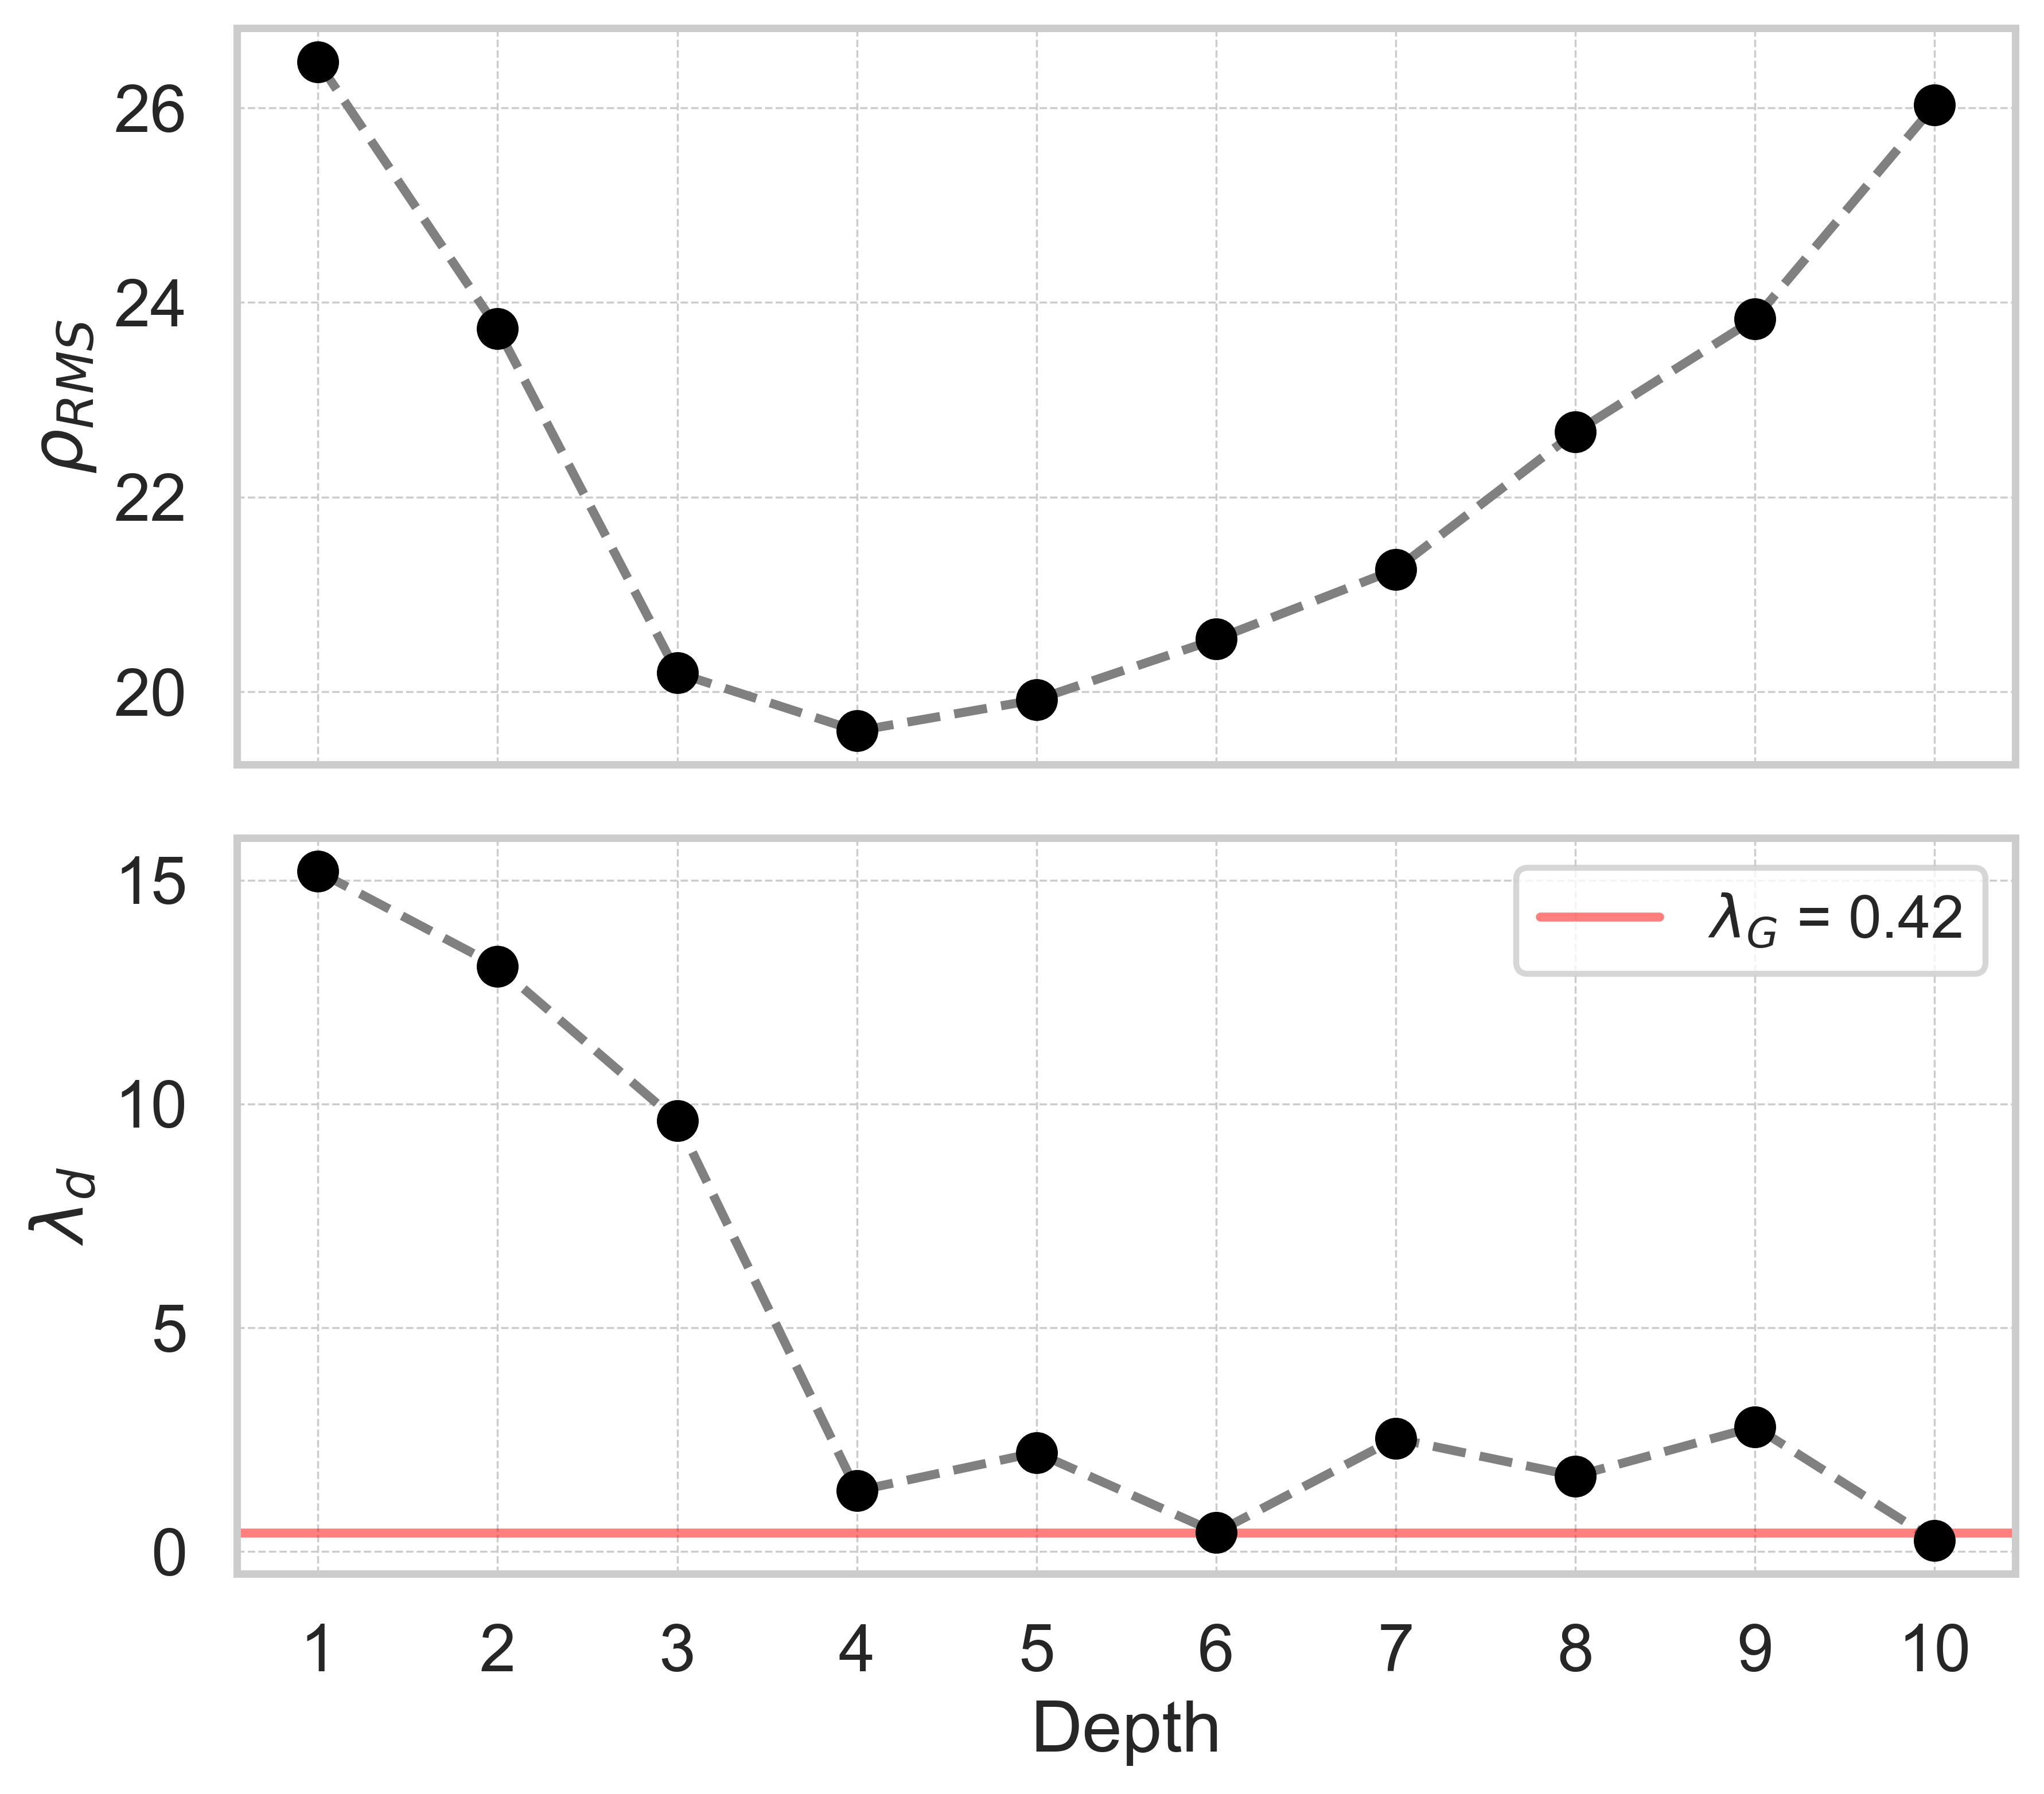

In [646]:
#set the height spacing to be smaller
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 7), dpi=500)
# Set the spacing between the subplots
fig.subplots_adjust(hspace=0.1)
sns.set_context("talk", font_scale=1)

# Shared colormap for depth
depths_arr = np.array(depths)
norm = Normalize(vmin=depths_arr.min(), vmax=depths_arr.max())
cmap = plt.cm.viridis
colors = [cmap(norm(d)) for d in depths_arr]

# ----- Top-right: RMS vs Depth -----
ax1.scatter(depths_arr, rms_values, color='black', zorder = 2)
ax1.plot(depths_arr, rms_values, '--', color='grey', zorder = 1)
ax1.set_ylabel(r"$\rho_{RMS}$")
# ax1.set_title("Spread of Optimal Parameters and Weighting of Objectives", fontsize = 'large')
ax1.set_xticks(depths_arr)
ax1.set_xticklabels([])
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# ----- Bottom-right: λ* vs Depth -----
ax2.scatter(depths_arr, lambda_stars, color = 'black', zorder = 2)
ax2.plot(depths_arr, lambda_stars, '--', color='grey', zorder = 1)
ax2.axhline(y=0.42, color='red', linestyle='-', zorder = 1, alpha = 0.5, label = r"$λ_G$" + f" = {0.42:.2f}")
ax2.set_xlabel("Depth")
ax2.set_xticks(depths_arr)
ax2.set_xticklabels(depths_arr)
ax2.set_ylabel(r"$\lambda_d$")
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend(loc='upper right', fontsize='small')
# ax2.set_title("λ* vs Depth", fontsize='large')

plt.show()